In [88]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mplt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import seaborn as sns
import math
import gc
import ipaddress
from urllib.parse import urlparse
from tldextract import extract
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPRegressor
from collections import Counter

import sys
from pathlib import Path
d = Path().resolve().parent.parent
sys.path.insert(0, str(d))
import util.utils as utils
import util.plot_utils as plot_utils

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb

np.set_printoptions(threshold=np.nan)

from sklearn.linear_model import LinearRegression



plt.rcParams["figure.figsize"] = (12,4)

from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from datetime import datetime


InteractiveShell.ast_node_interactivity = "all"

### Features
- dates
    - dayofyear
    - weekofyear
    - dayofweek
    - dayofmonth (salary credit effect)
    - Holidays from date_info.csv
- Visitors and reserve visitors
- Take all hotels for model, even ones not in submmission file
- Area by lat long
- reserve visitors can be used by per restaurant per day to gain some kind of intuition
- LabelEncode Store info

In [230]:

def label_encode_field(df,field):
    df[field] = df[field].fillna('-1')
    encoded_df = df[field]
    label_encoder = LabelEncoder()
    encoder = label_encoder.fit(encoded_df.values)
    
    encoded_df=encoder.transform(df[field].fillna("-1").values)
    df[field+"_encoded"] = encoded_df
    return encoder

df_air_store_info = pd.read_csv("data/air_store_info.csv")
label_encode_field(df_air_store_info,"air_genre_name")
label_encode_field(df_air_store_info,"air_store_id")
label_encode_field(df_air_store_info,"air_area_name")
df_air_store_info["air_lat_long"]=df_air_store_info["latitude"].astype(str)+"_"+df_air_store_info["longitude"].astype(str)
label_encode_field(df_air_store_info,"air_lat_long")

df_hpg_store_info = pd.read_csv("data/hpg_store_info.csv")
df_store_id_relation = pd.read_csv("data/store_id_relation.csv")
df_air_visit_data = pd.read_csv("data/air_visit_data.csv")

df_date_info = pd.read_csv("data/date_info.csv")
df_date_info.drop(['day_of_week'], axis = 1, inplace = True)
df_date_info["visit_date"]=df_date_info["calendar_date"]
df_date_info.drop(['calendar_date'], axis = 1, inplace = True)

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

In [231]:
def add_dates(df,date_col,date_format=None):
    timeseries = None
    if(date_format is None):
        timeseries = pd.to_datetime(df[date_col])
    else:
        timeseries = pd.to_datetime(df[date_col],format=date_format)
    df["dayofyear"] = timeseries.map(lambda x:x.dayofyear)
    df["dayofweek"] = timeseries.map(lambda x:x.dayofweek)
    df["weekofyear"] = timeseries.map(lambda x:x.weekofyear)
    df.loc[df["weekofyear"]==53,"weekofyear"] = 1
    df["dayofmonth"] = timeseries.map(lambda x:x.date().day)
    df["visit_date"] = timeseries.map(lambda x:str(x.date()))
    df["month"] = timeseries.map(lambda x:x.month)
    df = pd.merge(df,df_date_info,on="visit_date", how='left')
    #df.join(df_date_info,on='visit_date',how='left')
    return df
    
    

df_hpg_reserve = pd.read_csv("data/hpg_reserve.csv")

df_air_reserve = pd.read_csv("data/air_reserve.csv")

df_air_reserve = pd.merge(df_air_reserve,df_air_store_info,on='air_store_id', how='left')
df_air_reserve.drop(['reserve_datetime'], axis = 1, inplace = True)
df_hpg_reserve = pd.merge(df_hpg_reserve,df_hpg_store_info,on='hpg_store_id', how='left')
df_hpg_reserve.drop(['reserve_datetime'], axis = 1, inplace = True)

df_air_reserve=add_dates(df_air_reserve,"visit_datetime")
df_hpg_reserve=add_dates(df_hpg_reserve,"visit_datetime")



In [232]:
df_air_visit_data = pd.merge(df_air_visit_data,df_air_store_info,on='air_store_id', how='left')
df_air_visit_data = add_dates(df_air_visit_data,"visit_date")

In [233]:
sample_sub = pd.read_csv("data/sample_submission.csv")
len(sample_sub)

pred_ids = sample_sub.id.map(lambda x:x[:-11])
sample_sub["air_store_id"] = pred_ids
pred_dates = sample_sub.id.map(lambda x:x[-10:])
sample_sub["visit_date"] = pred_dates
sample_sub = add_dates(sample_sub,"visit_date")
sample_sub = pd.merge(sample_sub,df_air_store_info,on='air_store_id', how='left')
len(sample_sub)
sample_sub.head()


32019

32019

,id,visitors,air_store_id,visit_date,dayofyear,dayofweek,weekofyear,dayofmonth,month,holiday_flg,air_genre_name,air_area_name,latitude,longitude,air_genre_name_encoded,air_store_id_encoded,air_area_name_encoded,air_lat_long,air_lat_long_encoded
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,113,6,16,23,4,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,6,0,44,35.6940027_139.7535951,68
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,114,0,17,24,4,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,6,0,44,35.6940027_139.7535951,68
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,115,1,17,25,4,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,6,0,44,35.6940027_139.7535951,68
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,116,2,17,26,4,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,6,0,44,35.6940027_139.7535951,68
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,117,3,17,27,4,0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,6,0,44,35.6940027_139.7535951,68


In [6]:
# df_hpg_reserve.to_csv("data/stage-2/hpg_reserve.csv")

# df_air_reserve.to_csv("data/stage-2/air_reserve.csv")

# df_air_store_info.to_csv("data/stage-2/air_store_info.csv")

# df_date_info.to_csv("data/stage-2/date_info.csv")

# df_air_visit_data.to_csv("data/stage-2/air_visit_data.csv")
# sample_sub.to_csv("data/stage-2/sample_submission.csv")

In [234]:
df_air_visit_data.columns
output_column=["visitors"]
features = ["air_genre_name_encoded","air_store_id_encoded", 'air_area_name_encoded','air_lat_long_encoded', 'dayofyear', 'dayofweek', 'weekofyear',
       'dayofmonth', 'holiday_flg','month']
df_air_visit_data[features].dtypes

Index(['air_store_id', 'visit_date', 'visitors', 'air_genre_name',
       'air_area_name', 'latitude', 'longitude', 'air_genre_name_encoded',
       'air_store_id_encoded', 'air_area_name_encoded', 'air_lat_long',
       'air_lat_long_encoded', 'dayofyear', 'dayofweek', 'weekofyear',
       'dayofmonth', 'month', 'holiday_flg'],
      dtype='object')

air_genre_name_encoded    int64
air_store_id_encoded      int64
air_area_name_encoded     int64
air_lat_long_encoded      int64
dayofyear                 int64
dayofweek                 int64
weekofyear                int64
dayofmonth                int64
holiday_flg               int64
month                     int64
dtype: object

In [235]:
X = df_air_visit_data[features].values
y = df_air_visit_data[output_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=17)
X_pred = sample_sub[features].values

In [236]:
def loss(Y,A):
    y_1 = Y+1
    a_1 = A+1
    length = len(Y)
    return np.sqrt(np.sum(np.square(np.log(y_1) - np.log(a_1)))/length)

def objective(Y, A):
    Y=np.asarray(Y)
    A=np.asarray(A)
    y_1 = Y+1
    a_1 = A+1
    a_1_log = np.log(a_1)
    y_1_log = np.log(y_1)
    diff = y_1_log - a_1_log
    grad = -2 * diff/a_1
    hess = (-2*a_1_log+2*y_1_log+2)/np.square(a_1)
    return (grad,hess)

In [237]:

    

gc.collect()
xgr=xgb.XGBRegressor(n_estimators=1000, learning_rate=0.2, gamma=0,max_depth=8,n_jobs=36,objective=objective)
xgr.fit(X,y)

def xgr_predict(X):
    pred=xgr.predict(X)
    pred[pred<=0]=1
    return pred

623

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=36, nthread=None,
       objective=<function objective at 0x7f0a1862b620>, random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### NN Solution with sklearn

In [181]:
# model = MLPRegressor(hidden_layer_sizes=(500, 250,128,64,32,16,8,), activation='relu',batch_size=2000,learning_rate_init=0.001,max_iter=100,warm_start=True)
model = MLPRegressor(hidden_layer_sizes=(100,100,10,), activation='relu',batch_size=5000,learning_rate_init=0.01,max_iter=1000,warm_start=True)
model.fit(X_train,y_train)



/home/ahemf/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=0.0001, batch_size=2000, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 100, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)

In [182]:
def mlp_predict(X):
    pred=model.predict(X)
    pred[pred<=0]=1
    return pred

In [239]:
df_air_mean_visits = df_air_visit_data.groupby(["air_store_id"],as_index=False).mean()

y_preds = xgr_predict(X_pred)

print("mean loss:      %s" %loss(df_air_visit_data["visitors"],df_air_mean_visits["visitors"]))
print("All loss:       %s" %loss(y["visitors"],xgr_predict(X)))
print("Test loss:      %s" %loss(y_test["visitors"],xgr_predict(X_test)))
# print("\nMLP Test loss:  %s" %loss(y_test["visitors"],mlp_predict(X_test)))
# print("MLP All loss:  %s" %loss(y["visitors"],mlp_predict(X)))
# print("Train loss:     %s" %loss(y_train["visitors"],xgr_predict(X_train)))


mean loss:      0.0672178868136
All loss:       0.531253164325
Test loss:      0.53408593922


In [240]:
len(y_preds)


32019

In [241]:
sample_sub["visitors"] = y_preds

In [242]:
sample_sub.to_csv("results/Features-Engg_XGB_initial_model_1.csv",index=False,columns=["id","visitors"])

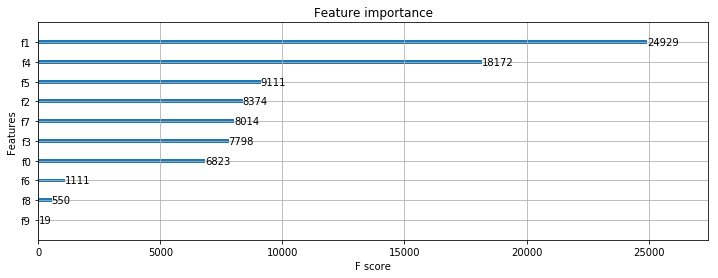

,feature,importance
1,air_store_id_encoded,29.362434
4,dayofyear,21.403751
5,dayofweek,10.731322
2,air_area_name_encoded,9.863253
7,dayofmonth,9.439229
3,air_lat_long_encoded,9.184815
0,air_genre_name_encoded,8.036419
6,weekofyear,1.308583
8,holiday_flg,0.647813
9,month,0.022379


In [243]:
def plot_importance(model,df,features):
    from xgboost import plot_importance
    plot_importance(model)
    plt.show()
    fi=model.feature_importances_

    fn=df[features].columns.values

    df_i=pd.DataFrame({"feature":fn,"importance":fi})
    df_i["importance"] = df_i["importance"]*100
    return df_i.sort_values("importance",ascending=False)

plot_importance(xgr,df_air_visit_data,features)